In [99]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [100]:
def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100):

    key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)

        E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels)],
        names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).to_frame('E')

        return E
    else:
        print(pdf)
        return pd.DataFrame(np.zeros((0, 0)))

In [101]:
subjects = range(1, 70)
sessions = [1]
pca_confounds = [True]
denoise = [False, True]
smoothed = [False, True]
masks = ['NPC12r', 'NPCr']
n_voxels = [50, 100, 250]

pred = []
for (sub, session, pcac, den, smooth, mask, nv) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels):
    pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv))

  0%|          | 0/1656 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.pca_confounds/sub-01/func/sub-01_ses-1_mask-NPC12r_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.smoothed.pca_confounds/sub-01/func/sub-01_ses-1_mask-NPC12r_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.smoothed.pca_confounds/sub-01/func/sub-01_ses-1_mask-NPCr_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.smoothed.pca_confounds/sub-01/func/sub-01_ses-1_mask-NPCr_nvoxels-100_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.smoothed.pca_confounds/sub-01/func/sub-01_ses-1_mask-NPCr_nvoxels-250_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.pca_confounds/sub-02/func/sub-02_ses-1_mask-NPC12r_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.smoothed.pca_confounds/sub-02/func/sub-02_ses-1_mask-NPC12r_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.

In [102]:
df = get_all_behavior(drop_no_responses=False)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)


In [103]:
pred = pd.concat(pred)

In [104]:
pred = pred.join(df, how='inner')

In [105]:
r1 = pred.groupby(['subject', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/2777660657.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [106]:
import seaborn as sns

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/2699782525.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  fac = sns.catplot(x='n_voxels', y='r', hue='glm',data=r1.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)


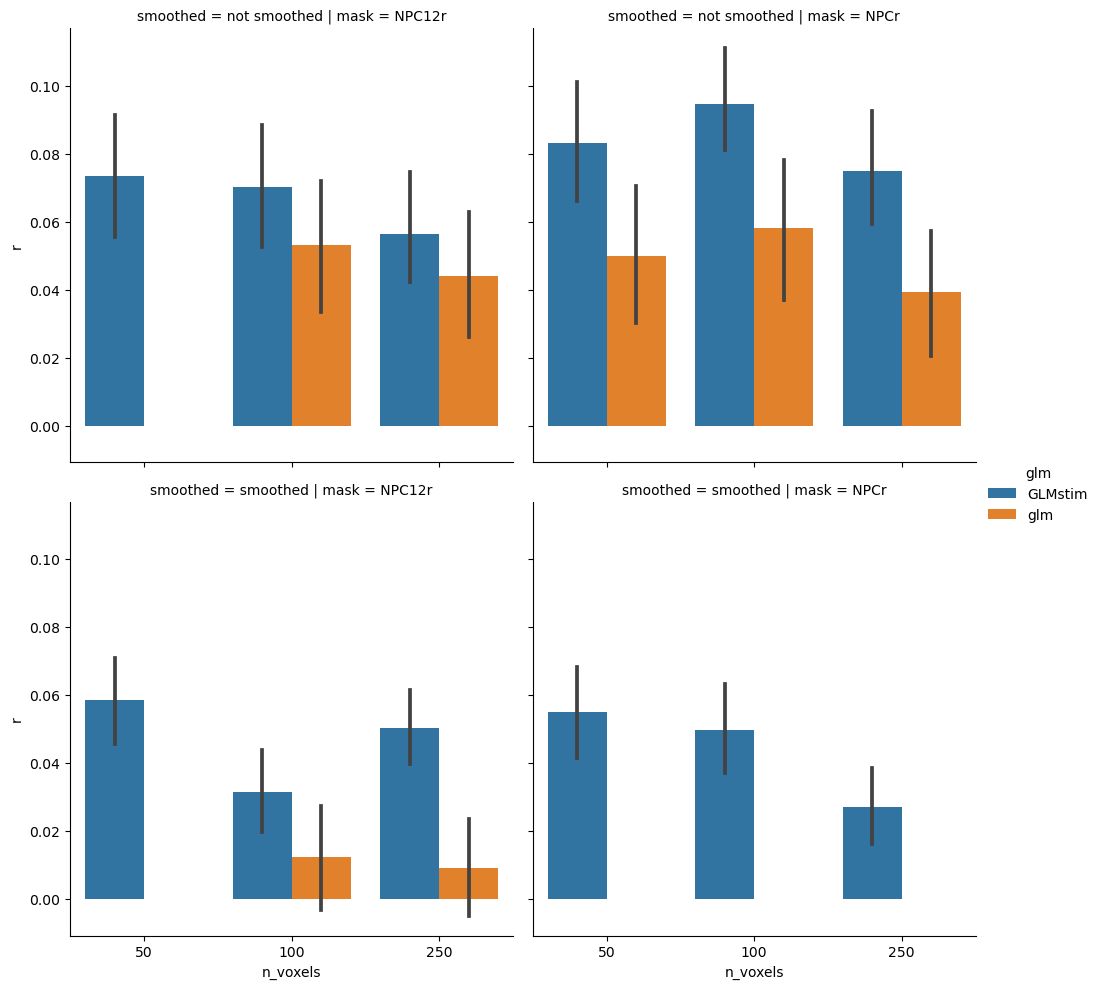

In [107]:
fac = sns.catplot(x='n_voxels', y='r', hue='glm',data=r1.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/1537915715.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  fac = sns.catplot(x='n_voxels', y='r', hue='glm',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)


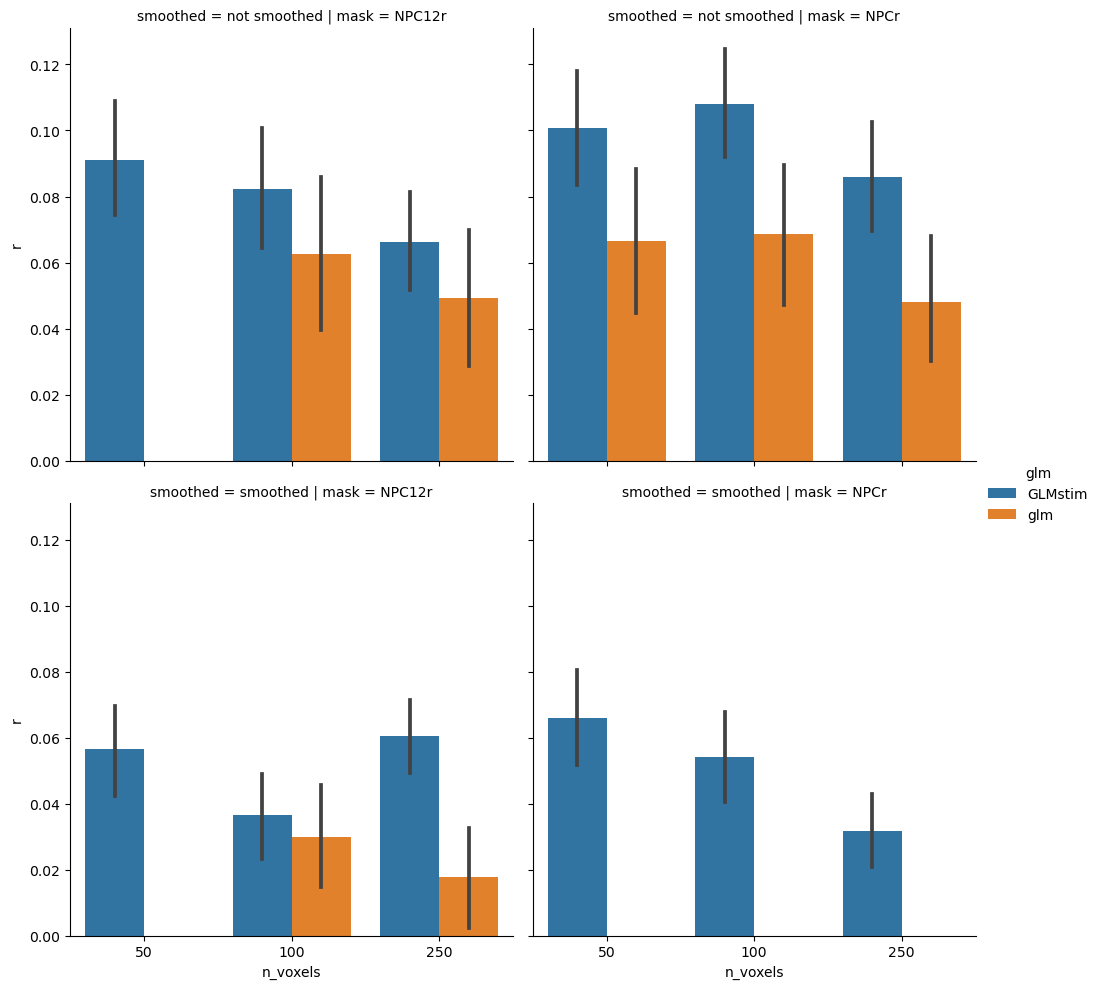

In [108]:
fac = sns.catplot(x='n_voxels', y='r', hue='glm',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, ci=67)

In [109]:
import pingouin

In [110]:
pingouin.ttest(r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('glm', 0, 'glm')['r'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.948932,63,two-sided,0.00447,"[0.02, 0.12]",0.368617,6.903,0.827348


In [111]:
pingouin.ttest(r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('GLMstim', 0, 'glm')['r'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.46558,58,two-sided,2.301127e-08,"[0.07, 0.14]",0.841747,5.571e+05,1.0


In [112]:
pingouin.pairwise_tests(data=r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').reset_index(), dv='r', subject='subject', within=['mask', 'glm'])

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/pairwise.py:477: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/pairwise.py:477: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/pairwise.py:582: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always

,Contrast,mask,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,mask,-,NPC12r,NPCr,True,True,-1.306965,58.0,two-sided,0.196383,0.319,-0.095471
1,glm,-,GLMstim,glm,True,True,1.143210,58.0,two-sided,0.257648,0.264,0.166114
2,mask * glm,NPC12r,GLMstim,glm,True,True,0.533277,58.0,two-sided,0.595880,0.163,0.076926
3,mask * glm,NPCr,GLMstim,glm,True,True,1.569433,58.0,two-sided,0.121987,0.452,0.241902


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


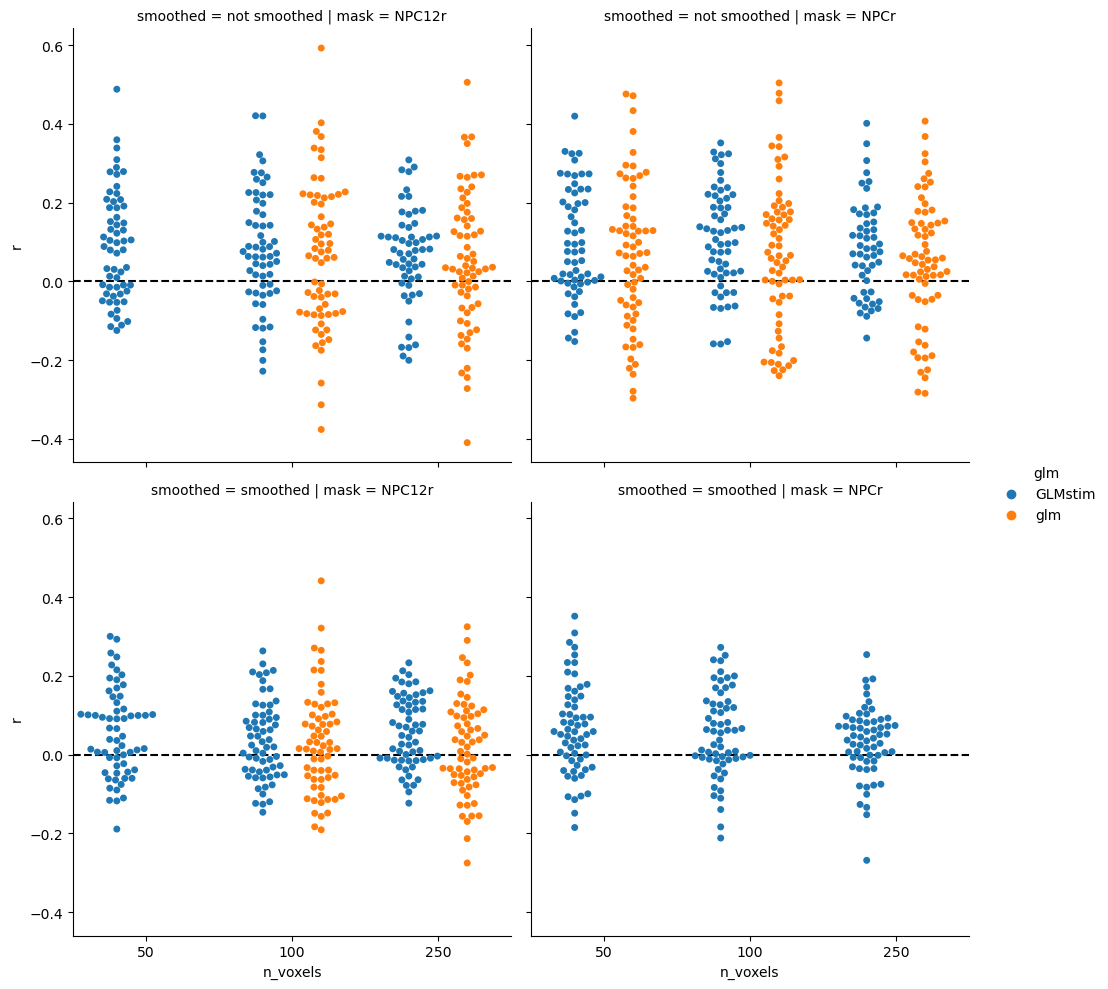

In [113]:
fac = sns.catplot(x='n_voxels', y='r', hue='glm',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True)

fac.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


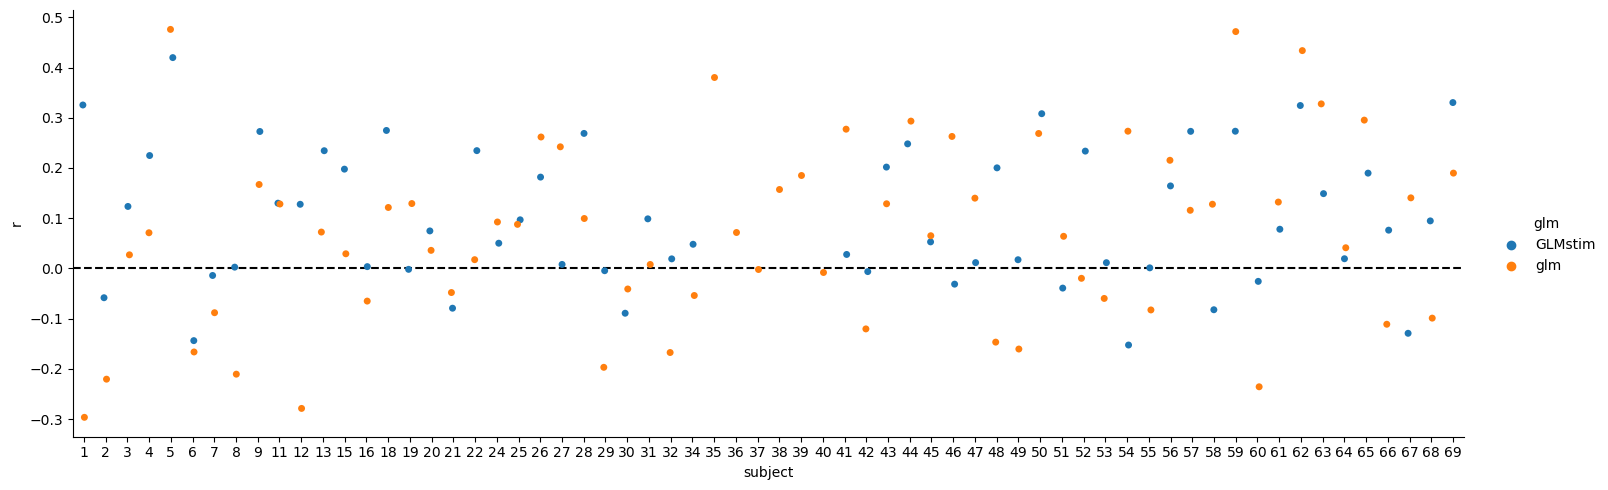

In [114]:
fac =sns.catplot(x='subject', y='r', data=r2.xs('not smoothed', 0, 'smoothed').xs(50, 0, 'n_voxels').xs('NPCr', 0, 'mask'), hue='glm', aspect=3)

fac.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

In [115]:
pingouin.ttest(r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('GLMstim', 0, 'glm')['r'], 0.0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.46558,58,two-sided,2.301127e-08,"[0.07, 0.14]",0.841747,5.571e+05,1.0


In [116]:
tmp = r2.unstack(['glm', 'smoothed', 'mask'])['r']
tmp[tmp['GLMstim'].isnull().any(1)]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/2919663108.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp[tmp['GLMstim'].isnull().any(1)]


glm                                 GLMstim                                \
smoothed                       not smoothed            smoothed             
mask                                 NPC12r      NPCr    NPC12r      NPCr   
subject pca           n_voxels                                              
4       pca_confounds 250          0.137045       NaN  0.075546 -0.268366   
8       pca_confounds 250          0.057028       NaN  0.089742  0.072143   
9       pca_confounds 250               NaN  0.306889  0.133014  0.068744   
18      pca_confounds 250          0.278669       NaN  0.014860  0.041657   
20      pca_confounds 250          0.078586       NaN  0.007040  0.015978   
21      pca_confounds 250         -0.036408       NaN  0.184914 -0.017063   
25      pca_confounds 250               NaN       NaN  0.072958  0.074052   
26      pca_confounds 250          0.114925       NaN -0.038462 -0.077561   
29      pca_confounds 250               NaN -0.042844 -0.008902 -0.006869   
31      pca_confounds 250               NaN       NaN  0.144907  0.052171   
34      pca_confounds 100         -0.096131  0.026061  0.063233       NaN   
35      pca_confounds 50                NaN       NaN  0.036019 -0.106829   
                      100               NaN       NaN  0.047238 -0.015298   
                      250               NaN       NaN       NaN  0.036898   
36      pca_confounds 50                NaN       NaN       NaN       NaN   
                      100               NaN       NaN       NaN       NaN   
                      250               NaN       NaN       NaN       NaN   
37      pca_confounds 50                NaN       NaN       NaN       NaN   
                      100               NaN       NaN       NaN       NaN   
                      250               NaN       NaN       NaN       NaN   
38      pca_confounds 50                NaN       NaN       NaN       NaN   
                      100               NaN       NaN       NaN       NaN   
                      250               NaN       NaN       NaN       NaN   
39      pca_confounds 50                NaN       NaN  0.099726  0.040516   
                      100               NaN       NaN  0.082346  0.059438   
                      250               NaN       NaN  0.212901  0.088522   
40      pca_confounds 50          -0.051696       NaN -0.117443  0.022506   
69      pca_confounds 50           0.289428  0.330203  0.091696       NaN   

glm                                     glm                      
smoothed                       not smoothed            smoothed  
mask                                 NPC12r      NPCr    NPC12r  
subject pca           n_voxels                                   
4       pca_confounds 250          0.127524  0.054096 -0.071016  
8       pca_confounds 250         -0.000362 -0.230579 -0.043389  
9       pca_confounds 250          0.267057  0.114054 -0.072891  
18      pca_confounds 250          0.212208  0.147240  0.233139  
20      pca_confounds 250          0.033513 -0.045365  0.037989  
21      pca_confounds 250         -0.100376  0.012626 -0.035603  
25      pca_confounds 250          0.118342  0.142885  0.008248  
26      pca_confounds 250         -0.027573  0.212693  0.058418  
29      pca_confounds 250         -0.036623 -0.188571 -0.035853  
31      pca_confounds 250         -0.009303  0.016867 -0.050670  
34      pca_confounds 100          0.079044  0.003516  0.022659  
35      pca_confounds 50                NaN  0.380809       NaN  
                      100         -0.123336  0.344150 -0.062919  
                      250          0.021984  0.260726  0.037814  
36      pca_confounds 50                NaN  0.073212       NaN  
                      100          0.143497  0.058546  0.214039  
                      250          0.086575  0.122858  0.123519  
37      pca_confounds 50                NaN -0.001813       NaN  
                      100         -0.134550 -0.205767  0.158276  
                 

In [117]:
print((r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('GLMstim', 0, 'glm')['r'] > 0.0).mean(), (r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('GLMstim', 0, 'glm')['r'] > 0.0).shape)
print((r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('glm', 0, 'glm')['r'] > 0.0).mean(), (r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask').xs('glm', 0, 'glm')['r'] > 0.0).shape)

0.7966101694915254 (59,)
0.6875 (64,)


In [118]:
from IPython.display import display

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/727212052.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]


glm,GLMstim,glm
count,59.000000,59.000000
mean,0.108168,0.069095
std,0.128504,0.187061
min,-0.159018,-0.239478
25%,0.021622,-0.048658
50%,0.106520,0.066102
75%,0.207679,0.176487
max,0.351762,0.504047


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.569433,58,two-sided,0.121987,"[-0.09, 0.01]",0.24348,0.452,0.452016


,n,r,CI95%,p-val,BF10,power
pearson,59,0.310677,"[0.06, 0.52]",0.016625,2.668,0.678012


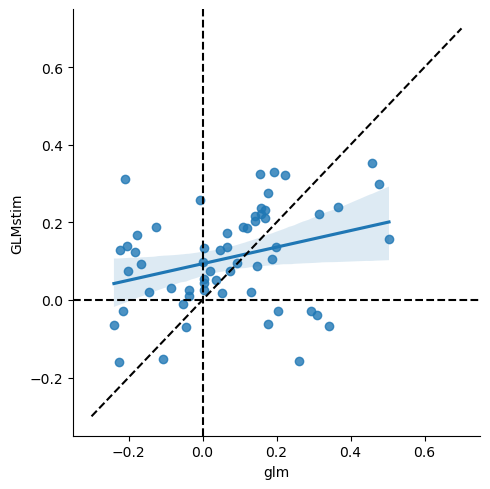

In [119]:
tmp = r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask')
tmp = tmp['r'].unstack('glm')

sns.lmplot(x='glm', y='GLMstim', data=tmp)
plt.plot([-.3, .7], [-.3, .7], c='k', ls='--')
plt.axhline(0,c='k', ls='--')
plt.axvline(0,c='k', ls='--')

tmp = tmp[~tmp.isnull().any(1)]
(tmp['glm'] > tmp['GLMstim']).mean()

display(tmp.describe())

display(pingouin.ttest(tmp['glm'], tmp['GLMstim'], paired=True))
display(pingouin.corr(tmp['glm'], tmp['GLMstim'], paired=True))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


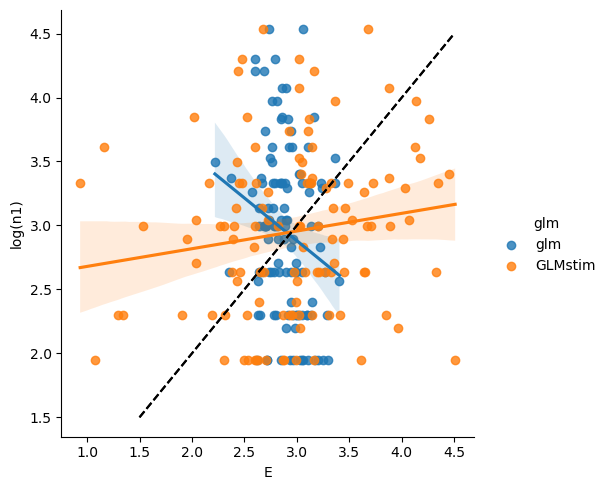

In [120]:
tmp = pred.loc[(32, 1, 'baseline', slice(None), 'pca_confounds', slice(None), 'not smoothed', 'NPCr', 100)]

fac = sns.lmplot(x='E', y='log(n1)', data=tmp.reset_index(), hue='glm')
fac.map(lambda *args, **kwargs: plt.plot([1.5, 4.5], [1.5, 4.5], c='k', ls='--'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


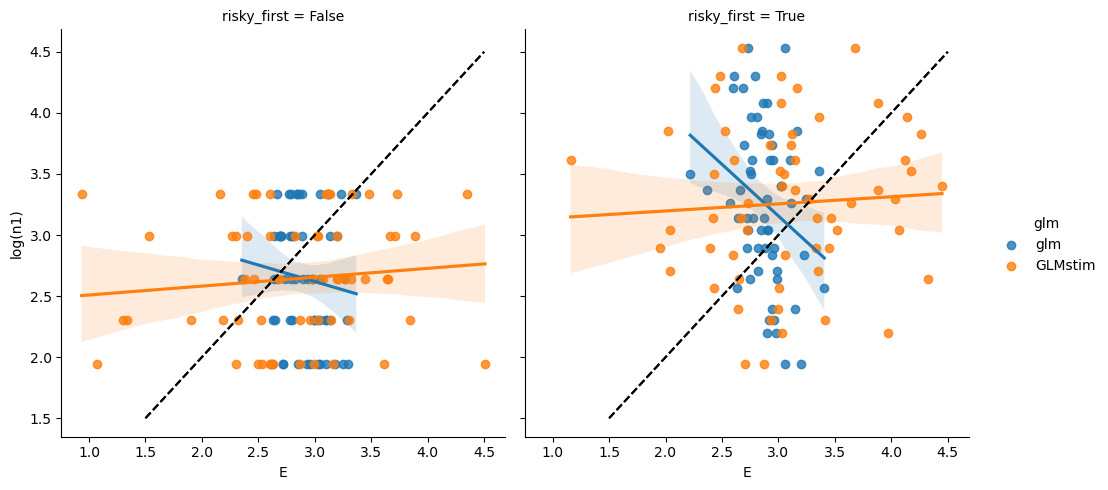

In [121]:
tmp = pred.loc[(32, 1, 'baseline', slice(None), 'pca_confounds', slice(None), 'not smoothed', 'NPCr', 100)]

fac = sns.lmplot(x='E', y='log(n1)', data=tmp.reset_index(), hue='glm', col='risky_first')
fac.map(lambda *args, **kwargs: plt.plot([1.5, 4.5], [1.5, 4.5], c='k', ls='--'))

<AxesSubplot: xlabel='pca-glm-smoothed-mask-n_voxels', ylabel='pca-glm-smoothed-mask-n_voxels'>

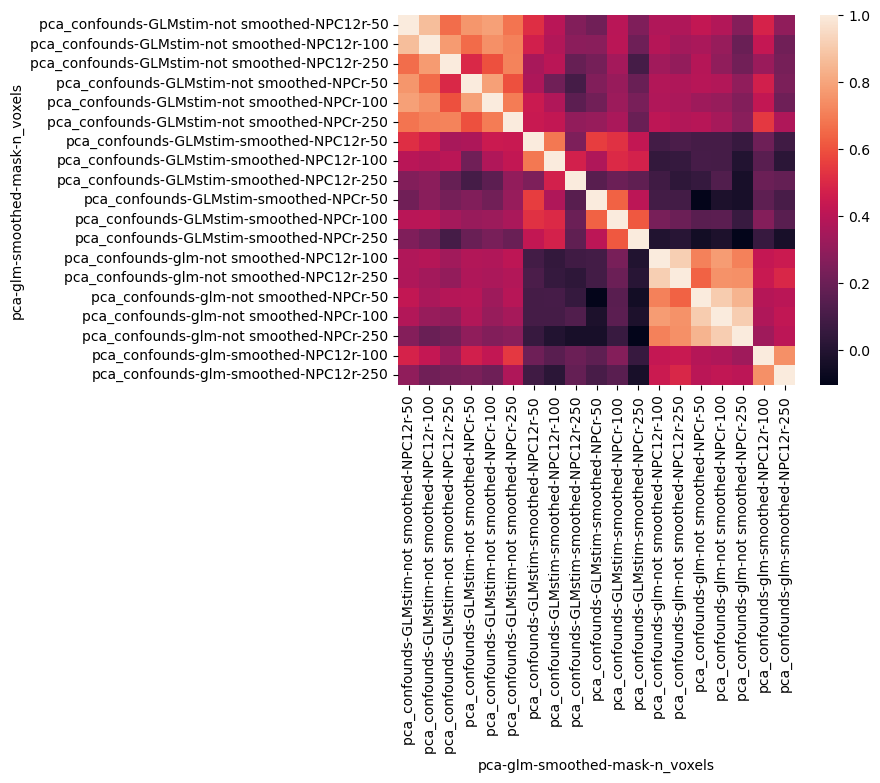

In [122]:
sns.heatmap(r2.unstack([1, 2, 3, 4, 5])['r'].corr())

In [123]:
import arviz as az

In [124]:
from tms_risk.cogmodels.fit_probit import build_model

In [125]:
import scipy.stats as ss
def invprobit(x):
    return ss.norm.ppf(x)

def extract_rnp_precision(trace, model, data, group=False):

    data = data.reset_index()

    if group:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique()[[0]],
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)
    else:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique(),
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False)['posterior']['chose_risky_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma

In [126]:
df = df.xs(1, 0, 'session')

df['x'] = df['log(risky/safe)']
df['chose_risky'] = df['chose_risky'].astype(bool)
df = df.reset_index()

In [127]:
model = build_model(df=df, model_label='2')

In [128]:
trace = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-probit2_trace.netcdf')

In [129]:
intercept, gamma = extract_rnp_precision(trace, model, df)

ValueError: shapes (1320,132) and (130,2000) not aligned: 132 (dim 1) != 130 (dim 0)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


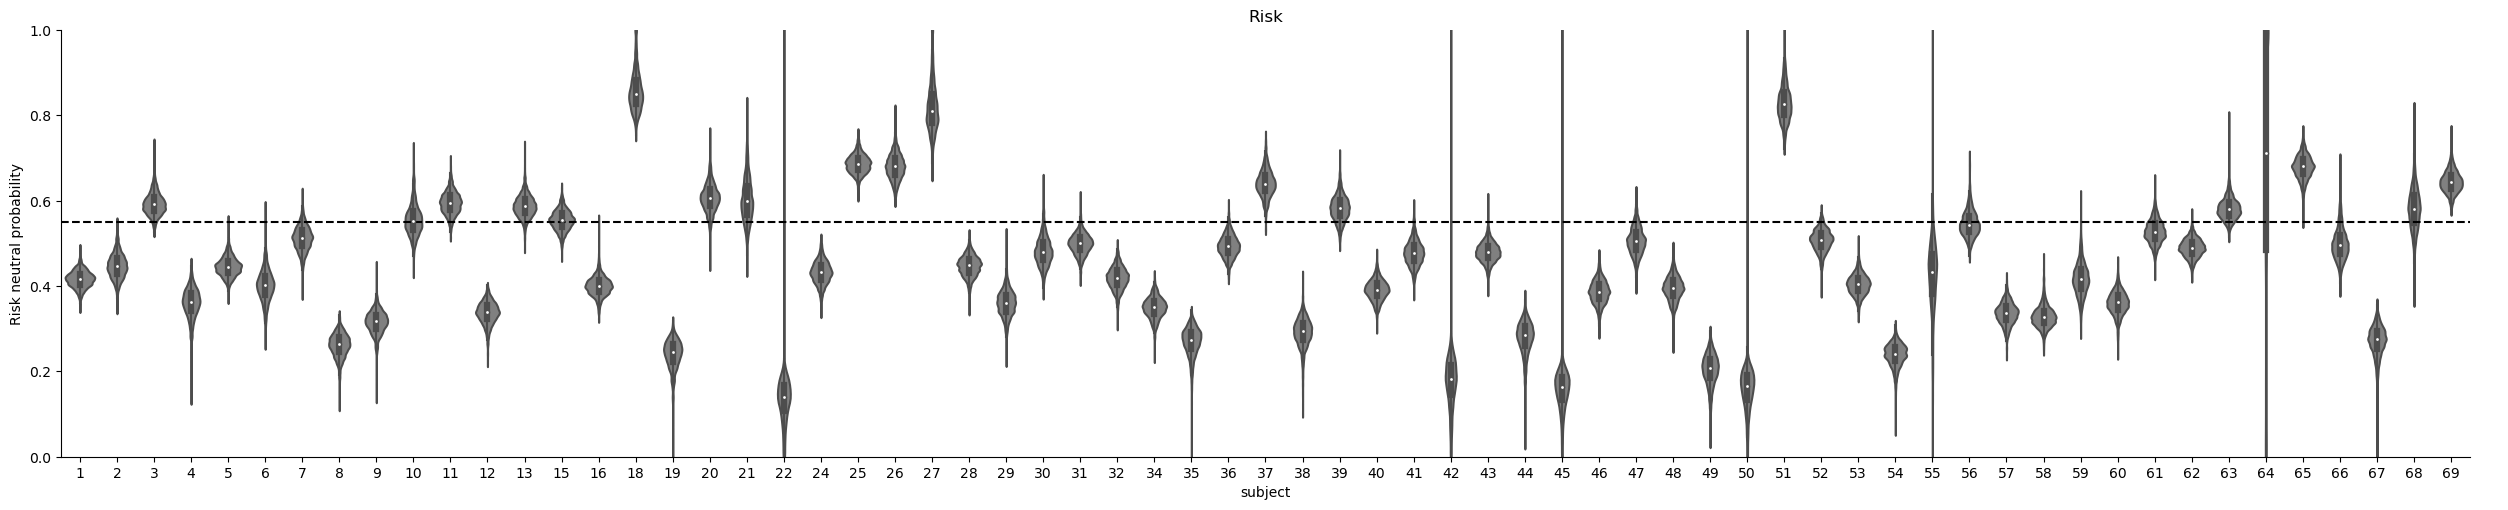

In [ ]:
import numpy as np

rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

fac = sns.catplot(x='subject', y='rnp', data=rnp.reset_index(), aspect=5., kind='violin', color='gray')
plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='Risk neutral probability')
fac.add_legend()

In [ ]:
r2 = r2.join(rnp.groupby('subject').mean())

In [ ]:
gamma = gamma.stack([1,2])
gamma.columns = ['gamma']

In [ ]:
r1 = r1.join(gamma.groupby('subject').mean())

In [ ]:
r = r1.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['gamma']))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

mask                                   NPC12r      NPCr    NPC12r      NPCr
glm                                   GLMstim   GLMstim       glm       glm
pca           smoothed     n_voxels                                        
pca_confounds not smoothed 50        0.306035  0.365903       NaN  0.242793
                           100       0.176997  0.311680  0.189537  0.301513
                           250       0.149224  0.071740  0.204035  0.284374
              smoothed     50        0.165939  0.064851       NaN       NaN
                           100       0.076006  0.018013  0.091756       NaN
                           250       0.107457  0.180349  0.183288       NaN

In [ ]:
trace = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-2_trace.netcdf')

In [ ]:
evidence_sd = trace.posterior['evidence_sd'].to_dataframe().unstack('presentation').groupby('subject').mean()

In [ ]:
r1 = r1.join(evidence_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/2619899885.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  r1 = r1.join(evidence_sd)


In [ ]:
r2 = r2.join(evidence_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/3760012201.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  r2 = r2.join(evidence_sd)


In [ ]:
r = r2.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d[('evidence_sd', 'first')]))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

mask                                   NPC12r      NPCr    NPC12r      NPCr
glm                                   GLMstim   GLMstim       glm       glm
pca           smoothed     n_voxels                                        
pca_confounds not smoothed 50       -0.321666 -0.307055       NaN -0.206073
                           100      -0.285485 -0.252220 -0.258389 -0.229426
                           250      -0.301443 -0.230305 -0.222460 -0.147165
              smoothed     50       -0.252711 -0.189951       NaN       NaN
                           100      -0.290808 -0.181196 -0.156972       NaN
                           250      -0.203468 -0.239675 -0.130477       NaN

In [ ]:
r = r1.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d[('evidence_sd', 'second')]))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

mask                                   NPC12r      NPCr    NPC12r      NPCr
glm                                   GLMstim   GLMstim       glm       glm
pca           smoothed     n_voxels                                        
pca_confounds not smoothed 50       -0.285383 -0.375604       NaN -0.109276
                           100      -0.105104 -0.318362  0.006999 -0.133332
                           250       0.106068 -0.001819  0.050335 -0.101337
              smoothed     50       -0.116371 -0.132375       NaN       NaN
                           100      -0.049254 -0.121099  0.043080       NaN
                           250      -0.127178 -0.073383  0.114014       NaN

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/3817463937.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  sns.scatterplot(rnp.groupby('subject').mean().join(evidence_sd), x=('evidence_sd', 'second'),


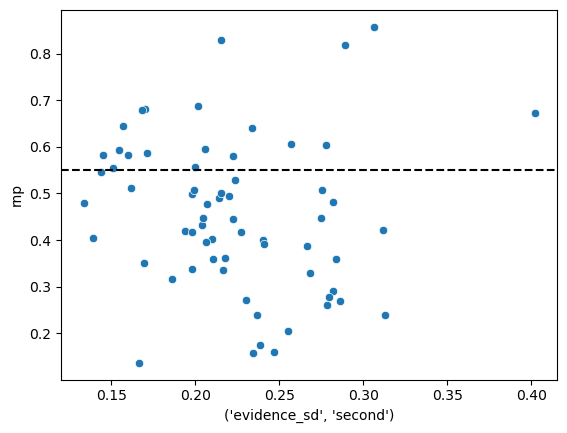

In [ ]:
sns.scatterplot(rnp.groupby('subject').mean().join(evidence_sd), x=('evidence_sd', 'second'),
 y='rnp')

plt.axhline(0.55, c='k', ls='--')